# ONS Boundaries - Choropleth Demo

Fragments associated with grabbing boundaries data.

*Note that a full demo using all local authority ditricts kills MyBinder demo.*

## Local Authority Districts (December 2016) Generalised Clipped Boundaries in the UK
Get the boundaries for Local Authority areas:

http://geoportal.statistics.gov.uk/datasets/7ff28788e1e640de8150fb8f35703f6e_2

In [1]:
import geopandas

#From the downloads area of the page, grab the link for the shapefile download
url='https://opendata.arcgis.com/datasets/7ff28788e1e640de8150fb8f35703f6e_2.zip?outSR=%7B%22wkid%22%3A27700%2C%22latestWkid%22%3A27700%7D'
gdf = geopandas.read_file(url)

#The .head() method limits the display of the table to the top few rows;
# THings like .head(20) to preview first 20 rows also works
gdf.head()

,objectid,lad16cd,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.359786e+07,69382.685924,"(POLYGON ((447097.0010000002 537152.0011, 4472..."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.387900e+07,42085.584812,(POLYGON ((449861.8997999998 521260.6998999994...
2,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,2.448388e+08,96189.660709,(POLYGON ((455776.7005000003 528322.4985000007...
3,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,2.049366e+08,115439.477112,(POLYGON ((444126.0993999997 528005.7992000002...
4,10,E06000010,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,7.145577e+07,63330.240277,(POLYGON ((510966.6001000004 436533.0030000005...


We can check the projection:

In [2]:
gdf.crs

{'proj': 'tmerc',
 'lat_0': 49,
 'lon_0': -2,
 'k': 0.9996012717,
 'x_0': 400000,
 'y_0': -100000,
 'datum': 'OSGB36',
 'units': 'm',
 'no_defs': True}

And preview the shapefile:

In [3]:
gdf.plot();

We can easily add a title to the plot:

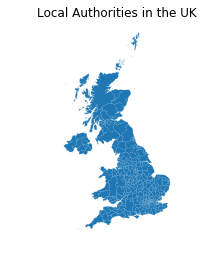

In [4]:
#Turn the plot into soemthing we can reference
ax = gdf.plot()

#Add a title
ax.set_title('Local Authorities in the UK')

#Turn off axes
ax.axis('off');

### Interactive Maps

Preview shapes from the first few rows using the `folium` package:

In [5]:
import folium

m = folium.Map(max_zoom=6, location=[53.9, 0.0])
folium.GeoJson(gdf.head()).add_to(m)
m

In [6]:
#You can download a copy of the actual boundary data file if required
# !wget https://opendata.arcgis.com/datasets/52182cdda64d4b15984f6446ca7ee7fd_1.zip?outSR=%7B%22wkid%22%3A27700%2C%22latestWkid%22%3A27700%7D -O wards_fullextent.zip
# !unzip wards_fullextent.zip

## Grab Data to Map Against

Let's get some data to use as the basis of a choropleth map.

We can use something from deprivation indices (we really should check we grabbed boundary files for the correct period...).

In [7]:
#https://www.gov.uk/government/statistics/english-indices-of-deprivation-2015
#File 10: local authority district summaries

data_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/464464/File_10_ID2015_Local_Authority_District_Summaries.xlsx'

Download the data into a `pandas` dataframe. The orginal file is an Excel spreadsheet with mutliple sheets, so let's load them all and preview the sheetnames:

In [8]:
import pandas as pd

df = pd.read_excel(data_url, sheet_name=None)

for k in df.keys():
    print(k)

Notes
IMD
Income
Employment
Education
Health
Crime
Barriers
Living
IDACI
IDAOPI


We an the preview the data in a single sheet:

In [9]:
df['Education'].head()

,Local Authority District code (2013),Local Authority District name (2013),"Education, Skills and Training - Average rank","Education, Skills and Training - Rank of average rank","Education, Skills and Training - Average score","Education, Skills and Training - Rank of average score","Education, Skills and Training - Proportion of LSOAs in most deprived 10% nationally","Education, Skills and Training - Rank of proportion of LSOAs in most deprived 10% nationally"
0,E06000001,Hartlepool,20101.48,72,30.510,47,0.2069,37
1,E06000002,Middlesbrough,22728.01,24,40.640,3,0.4419,1
2,E06000003,Redcar and Cleveland,19185.28,95,27.875,71,0.1818,54
3,E06000004,Stockton-on-Tees,16660.09,150,24.637,110,0.1750,59
4,E06000005,Darlington,16385.06,155,22.569,129,0.1385,75


## Generate a Choropleth Map

It's easy enough to combine data from a `pandas` data frame with shape data in a `geopandas` dataframe.

The `geopandas` dataframe is used to create a geojson file that the `folium` package can render. Each column name in the `geopandas` dataframe is mapped onto a corresponding `feature.properties.COLUMN_NAME` in the created geojson file. (I'm not sure offhand how column names that include space or punctuation characters are handled: simple column names are easiest.)

The data file is also passed in and the key and data columns identified as `columns=[KEYCOL, DATACOL]`.

The rendered choropleth map is then coloured accordingly.

In [10]:
import folium

m =  folium.Map(max_zoom=9, location=[54.5, -0.8])
folium.Choropleth(gdf.head(), key_on='feature.properties.lad16cd',
                  data=df['Education'], 
                  columns=['Local Authority District code (2013)',
                           'Education, Skills and Training - Rank of average rank'],
            fill_color='YlOrBr').add_to(m)
m

If we try to render the whole of the UK in a MyBinder session, things crash. (I think `geopandas` is quite heavy on resources.)

## Exploring the Data

We can exploit the notebook environment further by reating a simple application to explore the data more generally.

For example, within the `Education` data sheet, we can explore choropleth maps generated from other columns.

We can create tidied up names for the data selection that then refer back to the original column name:

In [11]:
#We can create a drop down list with values in the list that map onto column names
#A python dict is the data structure that lets us do this

#We use a technique called a dict comprehension to create the dict from a list of column names
#The split separates the column names on '-' elements into two parts
#The parts are refenced by a numercial index value, starting at 0
#Index value 1 is the second item in the split list
#The .strip() command gets rid of leading/trailing whitespace in the string
datacols = {c.split('-')[1].strip():c for c in df['Education'].columns if c.startswith('Education')}
datacols

{'Average rank': 'Education, Skills and Training - Average rank',
 'Rank of average rank': 'Education, Skills and Training - Rank of average rank',
 'Average score': 'Education, Skills and Training - Average score',
 'Rank of average score': 'Education, Skills and Training - Rank of average score',
 'Proportion of LSOAs in most deprived 10% nationally': 'Education, Skills and Training - Proportion of LSOAs in most deprived 10% nationally',
 'Rank of proportion of LSOAs in most deprived 10% nationally': 'Education, Skills and Training - Rank of proportion of LSOAs in most deprived 10% nationally'}

In [12]:
from ipywidgets import interact

@interact(Indicator=datacols)
def plotEducationChoropleth(Indicator='Education, Skills and Training - Rank of average rank'):
    m = folium.Map(max_zoom=9, location=[54.5, -0.8])
    folium.Choropleth(gdf.head(), key_on='feature.properties.lad16cd',
                      data=df['Education'], 
                      columns=['Local Authority District code (2013)',
                               Indicator],
                fill_color='YlOrBr').add_to(m)
    return m

interactive(children=(Dropdown(description='Indicator', index=1, options={'Average rank': 'Education, Skills a…

## Adding Data into Geodataframes

We can merge data into the geodataframe using common columns and then directly plot choropleth maps by selecting the data column we want to plot against.

In [13]:
#Merge in data
gdf = pd.merge(gdf, df['Education'], 
               how='inner',  #The type of join (what happens if data is in one dataset and not the other)
               left_on='lad16cd', #Column we're merging on in left dataframe
               right_on='Local Authority District code (2013)'#Column we're merging on in right dataframe
              )
gdf.head()

,objectid,lad16cd,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,Local Authority District code (2013),Local Authority District name (2013),"Education, Skills and Training - Average rank","Education, Skills and Training - Rank of average rank","Education, Skills and Training - Average score","Education, Skills and Training - Rank of average score","Education, Skills and Training - Proportion of LSOAs in most deprived 10% nationally","Education, Skills and Training - Rank of proportion of LSOAs in most deprived 10% nationally"
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.359786e+07,69382.685924,"(POLYGON ((447097.0010000002 537152.0011, 4472...",E06000001,Hartlepool,20101.48,72,30.510,47,0.2069,37
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.387900e+07,42085.584812,(POLYGON ((449861.8997999998 521260.6998999994...,E06000002,Middlesbrough,22728.01,24,40.640,3,0.4419,1
2,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,2.448388e+08,96189.660709,(POLYGON ((455776.7005000003 528322.4985000007...,E06000003,Redcar and Cleveland,19185.28,95,27.875,71,0.1818,54
3,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,2.049366e+08,115439.477112,(POLYGON ((444126.0993999997 528005.7992000002...,E06000004,Stockton-on-Tees,16660.09,150,24.637,110,0.1750,59
4,10,E06000010,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,7.145577e+07,63330.240277,(POLYGON ((510966.6001000004 436533.0030000005...,E06000010,"Kingston upon Hull, City of",25257.92,3,44.134,1,0.4217,2


We can now create a choropleth directly from the dataframe with an inline (non-interactive) plot:

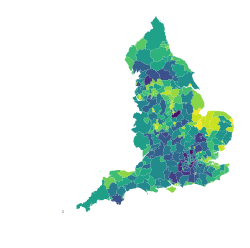

In [14]:
ax = gdf.plot(column='Education, Skills and Training - Average rank')
ax.axis('off');

Once again, we can create a simple widget driven app to allow us to explore the data more dynamically:

In [15]:
@interact(Indicator=datacols)
def plotEducationChoropleth2(Indicator='Education, Skills and Training - Rank of average rank'):
    ax = gdf.plot(column=Indicator)
    ax.axis('off');

interactive(children=(Dropdown(description='Indicator', index=1, options={'Average rank': 'Education, Skills a…

## Plot a region and it's neighbouring regions